### Video Classification using LSTM + Attention layer

In [47]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [48]:
mp_holist = mp.solutions.holistic 
mp_draw = mp.solutions.drawing_utils

In [49]:
def mediapipe_detection(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False                 
    result = model.process(img)                 # Make prediction
    img.flags.writeable = True                   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    return img, result

In [50]:
def draw_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS) # Draw face connections
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS) # Draw pose connections
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw left hand connections
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw right hand connections

In [51]:
def draw_styled_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
                             mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
                             mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
                             ) 
    # mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
    #                          mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
    #                          mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
    #                          ) 
    
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS,
                             mp_draw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [52]:
def extract_keypoints(results):
    pose=np.array([[res.x,res.y] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*2)
    left_hnd=np.array([[res.x,res.y] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*2)
    right_hnd=np.array([[res.x,res.y] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*2)
    face=np.array([[res.x,res.y] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*2)
    return np.concatenate([pose,left_hnd,right_hnd,face])
# concatenating for the model to detect the sign language

In [ ]:
import os 
video_dir = "C:/Users/araya/Desktop/keypoints/video_extract"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

In [54]:
# # For Training Only
# import os 
# video_dir = "C:/Users/araya/Desktop/vscode/Deep-learning-coding/MediaPipe/Data for different actions"
# video_list = []
# video_list = os.listdir(video_dir)

# len(video_list)

In [ ]:
video_list

In [56]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('Data for different actions')

actions = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [ ]:
actions

Collecting keypoint values for Training nd Testing

In [58]:
# Define the directory where your videos are stored
directory = "C:/Users/araya/Desktop/keypoints/video_extract"

In [59]:
# # For Training Only
# directory = "C:/Users/araya/Desktop/vscode/Deep-learning-coding/MediaPipe/Data for different actions"

In [ ]:
directory

In [ ]:
for filename in actions:
    print(directory + '/' + filename)

In [ ]:
file_paths = []
for action in actions:
    video_path = os.path.join('Data for different actions/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

In [63]:
def load_keypoint_sequences(file_paths):
    keypoint_sequences = []
    for file_path in file_paths:
        keypoints = np.load(file_path)
        keypoint_sequences.append(torch.tensor(keypoints, dtype=torch.float32))
    return keypoint_sequences

In [ ]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
sequences

In [ ]:
# Pad the sequences to the same length
from torch.nn.utils.rnn import pad_sequence
padded_sequences = pad_sequence(sequences, batch_first=True)
pad_sequence
print(padded_sequences.shape) # (batch_size, max_sequence_length, num_keypoints)

In [ ]:
labels = [action.split(".")[0] for action in actions]
labels

### Label

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

labels = le.fit_transform(labels)
labels

### For Traning only

In [68]:
# import pandas as pd
# df = pd.read_csv("script1.csv")

In [69]:
# labels = []

# for i in range(len(df.label)):
#     labels.append(df.label[i])

In [70]:
# labels

In [71]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Create a custom dataset
class KeypointDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        keypoints = np.load(self.file_paths[idx])
        label = self.labels[idx]
        return torch.tensor(keypoints, dtype=torch.float32), label

In [72]:
# Create the dataset
dataset = KeypointDataset(file_paths, labels)

In [ ]:
print(dataset.file_paths)
print(dataset.labels)

In [74]:
# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, torch.tensor(labels)

In [ ]:
# Create the DataLoader
batch_size = 16
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
data_loader

In [ ]:
for i, (data, label) in enumerate(data_loader):
    print(data.shape)
    print(label.shape)

In [ ]:
# Set device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

### LSTM

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: (batch_size, sequence_length, hidden_size)
        attention_scores = self.attention_weights(lstm_output)  # (batch_size, sequence_length, 1)
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, sequence_length, 1)
        weighted_output = torch.sum(lstm_output * attention_weights, dim=1)  # (batch_size, hidden_size)
        return weighted_output, attention_weights

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.pool = nn.MaxPool2d(kernel_size=(2,1), stride=1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = AttentionLayer(hidden_size)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, h, c):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Apply pooling before LSTM
        # x = self.pool(x)

        # Forward propagate the LSTM
        lstm_output, (h,c) = self.lstm(x, (h,c))

        # Apply attention to the LSTM output
        attention_output, attention_weights = self.attention(lstm_output)

        # Classification based on attention output
        out = self.fc1(attention_output)
        # out = self.dropout(out)
        out = self.fc2(out)
        return out, h, c

In [80]:
input_size = 1086
hidden_size = 256 
num_layers = 2
num_classes = 40

In [81]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size=1086, hidden_size=256, num_layers=2, num_classes=40, dropout=0.3).to(device)

In [ ]:
model

In [83]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification 
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [84]:
# #Load model
# model.load_state_dict(torch.load('saved_data/attention_lstm.pt'))
# optimizer.load_state_dict(torch.load('saved_data/optimizer.pt'))

In [85]:
# #Load model
# model.load_state_dict(torch.load('saved_data/fixed_attention_lstm.pt'))
# optimizer.load_state_dict(torch.load('saved_data/fixed_attention_lstm_optimizer.pt'))

In [ ]:
# Training loop
# References : https://saturncloud.io/blog/calculating-the-accuracy-of-pytorch-models-every-epoch/#:~:text=In%20order%20to%20calculate%20the,tensor%20along%20a%20specified%20dimension

from sklearn.metrics import f1_score, recall_score

num_epochs = 300
loss_logger = []
accuracy_logger = []
f1_logger = []
recall_logger = []

all_preds = []
all_labels = []
# n_epochs = []
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    model.train()

    h = torch.zeros(num_layers, batch_size, hidden_size).to(device)
    c = torch.zeros(num_layers, batch_size, hidden_size).to(device)

    for i, (sequences, labels) in enumerate(data_loader):
        # Move data to the device
        # labels = labels.type(torch.LongTensor)   # casting to long
        sequences = sequences.to(device)
        labels = labels.to(device)

        h = h.detach()
        c = c.detach()
        
        # Forward pass
        outputs, h, c = model(sequences, h, c)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Store predictions and labels for calculating metrics
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())    # Store true labels
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss_logger.append(loss.item())
    loss_logger.append(loss.item())
    accuracy = 100 * total_correct /total_samples

    # Calculate F1 score and recall
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
    recall = recall_score(all_labels, all_preds, average='weighted')

    f1_logger.append(f1)
    recall_logger.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} , Accuracy : {accuracy:.2f}%, F1 Score: {f1:.2f}, Recall: {recall:.2f}')
    accuracy_logger.append(accuracy)
    # n_epochs.append(epoch)

In [108]:
loss_logger

[3.7468531131744385,
 3.7433433532714844,
 3.7379350662231445,
 3.7317440509796143,
 3.7245774269104004,
 3.7163968086242676,
 3.7063961029052734,
 3.6975574493408203,
 3.6698546409606934,
 3.646960973739624,
 3.611898183822632,
 3.573371648788452,
 3.54199481010437,
 3.5188024044036865,
 3.4374966621398926,
 3.4295730590820312,
 3.3859500885009766,
 3.4112179279327393,
 3.333994150161743,
 3.2811033725738525,
 3.2301278114318848,
 3.2260141372680664,
 3.1488687992095947,
 3.23184871673584,
 3.3031394481658936,
 3.0875933170318604,
 3.216387987136841,
 3.0945942401885986,
 3.0562427043914795,
 3.064333915710449,
 3.0105607509613037,
 2.9203803539276123,
 2.939545154571533,
 2.9410364627838135,
 2.808842182159424,
 2.817873239517212,
 2.7620091438293457,
 2.796067953109741,
 2.683180093765259,
 2.6258015632629395,
 2.6291754245758057,
 2.7485876083374023,
 2.5610477924346924,
 2.7427473068237305,
 2.64457631111145,
 2.5088775157928467,
 2.492525577545166,
 2.381911039352417,
 2.33039999

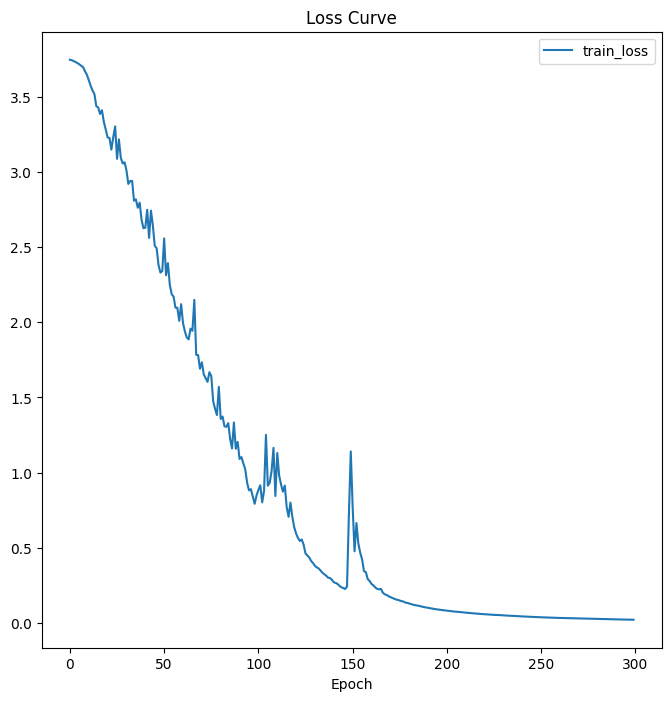

In [109]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Loss Curve")
plt.plot(loss_logger, label='train_loss')
# plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

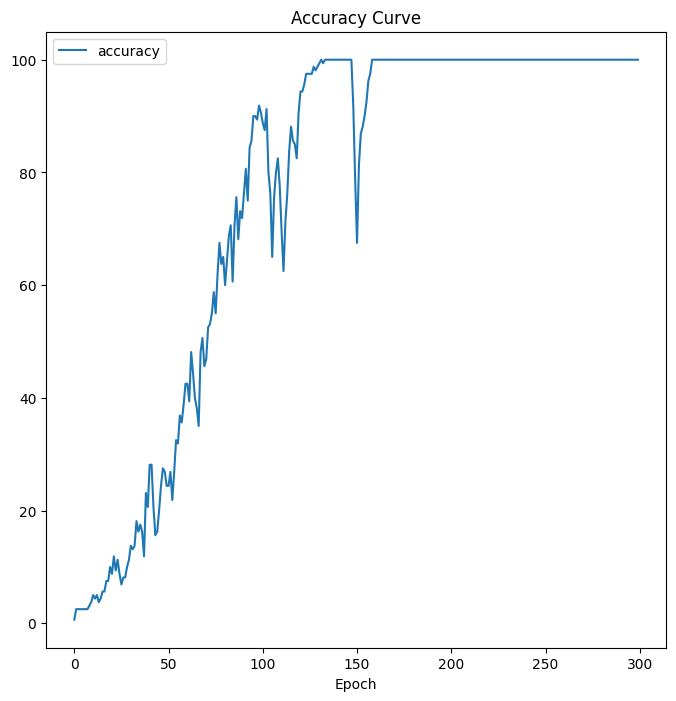

In [110]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Accuracy Curve")
# plt.plot(loss_logger, label='train_loss')
plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [90]:
def check_accuracy(loader, model, h, c):
    if data_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")  
          
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            # x = x.reshape(x.shape[0], -1)
            
            scores,h,c = model(x,h,c)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
        
    model.train()

In [91]:
# h = torch.zeros(num_layers, 8, hidden_size).to(device)
# c = torch.zeros(num_layers, 8, hidden_size).to(device)

In [ ]:
check_accuracy(data_loader, model,h,c)
# check_accuracy(test_loader, model)

### Save and Load Model

In [ ]:
pad_sequence(sequences, batch_first=True)

In [ ]:
# Put the model in evaluation mode
model.eval()

# No need to track gradients during inference
with torch.no_grad():
    # Get the model's output (logits)
    outputs = model(padded_sequences.to(device),h,c)

# outputs = torch.softmax(outputs, dim=1)
# outputs = torch.max(outputs,1)

outputs


In [ ]:
padded_sequences

In [96]:
file_paths = ["Data for different actions/เขิน.mp4/เขิน.npy"]

In [ ]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
# Change list to numpy array 
sequences = np.array(sequences)
# Change numpy array to tensor
sequences = torch.FloatTensor(sequences)
sequences = pad_sequence(sequences, batch_first=True)
sequences

In [ ]:
outputs = model(sequences.to(device))
outputs

In [ ]:
labels = [action.split(".")[0] for action in actions]
labels

In [100]:
# Change from tensor to numpy arrat
outputs = outputs.cpu().detach().numpy()

In [ ]:
outputs

In [ ]:
for idx, word in enumerate(outputs):
    # max_value = torch.max(outputs)
    list_outputs = max(outputs)
    print(list_outputs)
    # print(max_value)
    # print(max_value.detach().numpy())

In [ ]:
index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)
index_max

In [ ]:
print(labels[index_max])

In [105]:
# Test accuracy on training dataset
import os 
video_dir = "C:/Users/araya/Desktop/vscode/Deep-learning-coding/MediaPipe/Data for different actions"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

Model_Data=os.path.join('Data for different actions')

actions = np.array(video_list)

In [ ]:
train_name = [action.split(".")[0] for action in actions]
train_name

In [ ]:
correct = 0
num_clip = 0
for clip in train_name:
    # print(clip)
    file_paths = [f"Data for different actions/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)

    outputs = model(sequences.to(device),h,c)

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    clip = clip.split("_")[0]

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

In [ ]:
print(labels)

In [362]:
# import os 
# video_dir = "C:/Users/araya/Desktop/augments"
# video_list = []
# video_list = os.listdir(video_dir)

# len(video_list)

In [ ]:
import os 
video_dir = "C:/Users/araya/Desktop/vscode/Deep-learning-coding/MediaPipe/Test"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

In [103]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('../MediaPipe/Test')

actions_test = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [ ]:
labels_test = [action.split(".")[0] for action in actions_test]
labels_test

In [ ]:
file_paths = []
for action in actions_test:
    video_path = os.path.join('Test/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

In [ ]:
file_paths

In [ ]:
correct = 0
num_clip = 0
for clip in labels_test:
    # print(clip)
    file_paths = [f"Test/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    clip = clip.split("_")[0]

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

### Save Model

In [46]:
# torch.save(model.state_dict(), 'saved_data/attention_lstm.pt')
# torch.save(optimizer.state_dict(), 'saved_data/optimizer.pt')
# # torch.save(scheduler.state_dict(), 'saved_data/scheduler.pt')

### Real-Time Prediction

In [683]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 

In [684]:
mp_holist = mp.solutions.holistic 
mp_draw = mp.solutions.drawing_utils

In [685]:
def mediapipe_detection(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False                 
    result = model.process(img)                 # Make prediction
    img.flags.writeable = True                   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    return img, result

In [686]:
def draw_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS) # Draw face connections
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS) # Draw pose connections
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw left hand connections
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw right hand connections

In [687]:
def draw_styled_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
                             mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
                             mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
                             ) 
    # mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
    #                          mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
    #                          mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
    #                          ) 
    
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS,
                             mp_draw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [688]:
def extract_keypoints(results):
    pose=np.array([[res.x,res.y] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*2)
    left_hnd=np.array([[res.x,res.y] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*2)
    right_hnd=np.array([[res.x,res.y] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*2)
    face=np.array([[res.x,res.y] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*2)
    return np.concatenate([pose,left_hnd,right_hnd,face])
# concatenating for the model to detect the sign language

In [656]:
# # Initialize MediaPipe holistic model
# mp_holistic = mp.solutions.holistic
# holistic = mp_holistic.Holistic()

# # Initialize OpenCV video capture
# cap = cv2.VideoCapture(0)

# sequence = []
# sequence_length = 160

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break
    
#     # Convert the image to RGB (MediaPipe expects RGB images)
#     image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
#     # Process the frame with MediaPipe
#     results = holistic.process(image_rgb)
    
#     # Extract keypoints (face, hands, and pose landmarks)
#     # Assume extract_keypoints function converts keypoints into a flattened vector of size 1662
#     keypoints = extract_keypoints(results) 
    
#     # Append keypoints to the sequence buffer
#     sequence.append(keypoints)
    
#     # Ensure the sequence only keeps the last 160 frames
#     if len(sequence) > sequence_length:
#         sequence.pop(0)
    
#     if len(sequence) == sequence_length:
#         # Convert sequence to tensor
#         input_tensor = torch.tensor([sequence], dtype=torch.float32)
        
#         # Make predictions
#         with torch.no_grad():
#             prediction = model(input_tensor.to(device))
        
#         # Decode and display the prediction
#         predicted_class = torch.argmax(prediction, dim=1).item()
#         print(f"Predicted Class: {predicted_class}")
    
#     # Display the video frame
#     cv2.imshow('Real-time Sign Language Recognition', frame)
    
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

In [657]:
# # Function to apply CLAHE for light normalization
# def apply_clahe(frame):
#     # Convert to grayscale
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
#     # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     equalized = clahe.apply(gray)
    
#     # Convert back to BGR after CLAHE
#     frame_clahe = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)
    
#     return frame_clahe

In [658]:
from rembg import remove

In [ ]:
threshold = 0.5  # Confidence threshold for prediction

cap = cv2.VideoCapture(0)
sequence = []
sequence_length = 60
# Set mediapipe model 
with mp_holist.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.01,static_image_mode=False, 
    model_complexity=1,) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        # frame = apply_clahe(frame)

        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        keypoints = extract_keypoints(results)

        if keypoints.any():
            sequence.append(keypoints)

            if len(sequence) > sequence_length:
                sequence = []
        
            if len(sequence) == sequence_length:
                # Convert sequence to tensor
                input_tensor = torch.tensor([sequence], dtype=torch.float32)
                sequence = []
            
                # Make predictions
                with torch.no_grad():
                    prediction = model(input_tensor.to(device))
            
                # Get predicted class
                predicted_class_idx = torch.argmax(prediction, dim=1).item()
                predicted_class_label = labels[predicted_class_idx]
                confidence = torch.softmax(prediction, dim=1)[0][predicted_class_idx].item()

                # Display prediction result
                if confidence > threshold:
                    cv2.putText(image, f'{predicted_class_label} ({confidence:.2f})', (50, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                    print(predicted_class_label)
        
        draw_styled_landmarks(image, results)

        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [681]:
cap.release()
cv2.destroyAllWindows()

### Save & Load Model Command

In [1061]:
# torch.save(model.state_dict(), 'saved_data/attention_lstm.pt')
# torch.save(optimizer.state_dict(), 'saved_data/optimizer.pt')
# # torch.save(scheduler.state_dict(), 'saved_data/scheduler.pt')

In [ ]:
# #Load model
# model.load_state_dict(torch.load('saved_data/model_name.pt'))
# optimizer.load_state_dict(torch.load('saved_data/optimizer_namae.pt'))